<hr/> <h1 style="text-align: center;"><span style="color: #666699;"<em><strong>  PROJET ANALYSE DE SENTIMENTS OpenAI </strong></em></span></h1><hr />

**Objectif :** Créer un système de surveillance des informations en ligne pour un ensemble d'articles publiées sur le site Forbes.com sur OpenAI afin de distinguer les articles à conotation positve, négative ou neutre.

**Étapes du Projet :**

1. Collecte de Données 

Utiliser le web scraping  pour collecter les informations : titre, contenu, date de publication et url de chaque article.

2. Traitement des Données 

Créer un dataframe pour stocker les données et faire un pré traitement du texte

3. Analyse de sentiments 

Mettre en place un mécanisme de détection de l'attitude émotionnelle dominante dans chaque article.

4. Visualisation des Données 

Créer des visualisations simples pour afficher les tendances 

In [185]:
# Importer les packages
from selenium import webdriver
from selenium.webdriver.common.by import By

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from dateutil import parser
import nltk
from nltk import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from time import sleep

nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Fonctions génériques

In [155]:
# Fonction de récupération du code source du site
def get_soup(url,nb_clicks):
    """Cette fonction récupère le code source d'un site web grâce au 
    framework selenium après avoir cliqué plusieurs fois sur le bouton
    'More Articles'
    Paramètres
    -----------
    url : adresse ou lien du site
    nb_clicks : nombre de clicks à faire
    Returns
    ---------
    soup : Document HTML du code source du site"""
    try :
        # Ouverture de la fenêtre de recherche Chrome
        driver = webdriver.Chrome()
        # Ouverture de la page à scraper
        driver.get("https://www.forbes.com/search/?q=OpenAI&sh=f300ab8279f4")
        driver.implicitly_wait(5)
        i = 0
        while i < nb_clicks:
            # Cliquer sur le bouton "More Articles"
            driver.find_element(By.CLASS_NAME,value="search-more").click()
            # Attendre un court instant de 2 secondes
            sleep(10)
            i+=1

        # Récupérer le contenu HTML de la nouvelle page après tous les clics
        page_source = driver.page_source
        soup = BeautifulSoup(page_source,"html.parser")
        driver.close()
        return soup
    
    except ValueError :
        print("Erreur du chargement de la page")
        return None

In [156]:
# Fonction de conversion au format ISO 8601
def to_iso(date_pub):
    iso_date=parser.parse(date_pub,fuzzy_with_tokens=True)[0].isoformat()
    return iso_date

In [157]:
# Fonction de récupération des détails pour chaque article
def get_articles(url,nb_clicks):
    """Cette fonction récupère les détails sur chaque article.
    Paramètres
    -----------
    url : adresse ou lien du site
    nb_clicks : nombre de clicks à faire
    Returns
    ---------
    data : dataframe contenant les différentes informations"""
    titles = []
    contents = []
    dates = []
    urls = []
    f = lambda x : x.text.strip() if x else "--"
    soup = get_soup(url,nb_clicks)
    articles = soup.find_all("article")
    for elt in articles :
        # Titre 
        title = elt.find("h3").text
        # Contenu 
        content = elt.find("div",class_="stream-item__description").text.strip()
        # Date de publication
        date = elt.find("div",class_="stream-item__date").text.strip()
        # Url
        url = elt.find("a",class_="stream-item__title")["href"]
        
        # Ajout aux listes
        titles.append(title)
        contents.append(content)
        dates.append(to_iso(date))
        urls.append(url)
    
    # Mise en place du dataframe
    data = pd.DataFrame({"title":titles,"content":contents, "date_publication" : dates,"urls":urls})
    return data

In [158]:
# Fonction de prétraitement des textes
def treatment_text(text):
    """Cette fonction effectue le prétraitement d'un corpus : suppression des ponctuations
    et des caractères spéciaux, standardisation en miniscule, suppression des 
    stop-words et lemmatization.
    Paramètres
    ----------
    text : texte (str) à traiter
    Returns
    --------
    final_text : texte (str) traité"""
    # Ramener en minuscules
    text = text.lower()
    # Suppression des caractères spéciaux et de la ponctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Tokéninastion
    text = word_tokenize(text)
    # Définir la liste des stop-words
    stop_words = set(stopwords.words("english"))
    # Enlever les stop_words
    text = [elt for elt in text if elt not in stop_words]
    # Lématization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(elt) for elt in text]
    # Ramener le texte à sa valeur normale
    text = " ".join(text)
    return text

In [176]:
# Fonction de détection du sentiment
def get_sentiment(text):
    # Instancier l'analyseur de sentiment
    analyzer = SentimentIntensityAnalyzer()
    # Calculer la polarité du texte
    score = analyzer.polarity_scores(text)
    if score["compound"] == 0 :
        return "Neutre"
    elif score["compound"] > 0 :
        return "Positif"
    else :
        return "Negatif"

In [183]:
def generate_worcloud(text,title):
    """Cette fonction génère et affiche le nuage de mots d'un corpus
    Paramètres
    ----------
    text : texte (str) à afficher
    title : titre (str) du nuage de mots"""
    cloud = WordCloud(background_color='white').generate(text)
    plt.axis(False)
    plt.title(title)
    plt.imshow(cloud)

## 1. Collecte de Données

In [161]:
data = get_articles("https://www.forbes.com/search/?q=OpenAI&sh=1b0012a6279f",40)

In [162]:
data

,title,content,date_publication,urls
0,OpenAI’s Sora Challenges The Art Of Medicine,Practicing medicine is an art. This fundamenta...,2024-02-17T00:00:00,https://www.forbes.com/sites/talpatalon/2024/0...
1,Non-Profit Board Governance: Lessons From Harv...,Service on a non-profit’s board of directors i...,2024-02-20T00:00:00,https://www.forbes.com/sites/billconerly/2024/...
2,Did OpenAI Sora Just Kickstart The Era Of Gene...,"OpenAI's Sora, a groundbreaking text-to-video ...",2024-02-20T00:00:00,https://www.forbes.com/sites/bernardmarr/2024/...
3,How OpenAI’s Sora Impacts The Future Of Music ...,"At the onset of OpenAI's Sora launch, marketer...",2024-02-17T00:00:00,https://www.forbes.com/sites/sashawallinger/20...
4,Business Tech Roundup: OpenAI Is Testing A Bet...,Plus: Gmail is about to reject more of your ma...,2024-02-18T00:00:00,https://www.forbes.com/sites/quickerbettertech...
...,...,...,...,...
215,Catch The Next Big Tech AI Wave: Startups Floc...,"""Both Chat GPT and DALL-E are already being us...",2023-03-22T00:00:00,https://www.forbes.com/sites/forbesbooksauthor...
216,"Exclusive: Bill Gates On Advising OpenAI, Micr...",The Microsoft cofounder talked to Forbes about...,2023-02-06T00:00:00,https://www.forbes.com/sites/alexkonrad/2023/0...
217,OpenAI Positioned Itself As The AI Leader In ...,2022 marked the year generative models made th...,2022-12-29T00:00:00,https://www.forbes.com/sites/johanmoreno/2022/...
218,Seven Technology Leaders Agree To AI Safeguards,"This article discusses Amazon, Google, Inflect...",2023-07-31T00:00:00,https://www.forbes.com/sites/cindygordon/2023/...


## 2. Traitement des Données

In [168]:
data["content_nettoye"] = data["content"].apply(treatment_text)

In [169]:
data

,title,content,date_publication,urls,content_nettoye
0,OpenAI’s Sora Challenges The Art Of Medicine,Practicing medicine is an art. This fundamenta...,2024-02-17T00:00:00,https://www.forbes.com/sites/talpatalon/2024/0...,practicing medicine art fundamental view share...
1,Non-Profit Board Governance: Lessons From Harv...,Service on a non-profit’s board of directors i...,2024-02-20T00:00:00,https://www.forbes.com/sites/billconerly/2024/...,service nonprofit board director mostly dull w...
2,Did OpenAI Sora Just Kickstart The Era Of Gene...,"OpenAI's Sora, a groundbreaking text-to-video ...",2024-02-20T00:00:00,https://www.forbes.com/sites/bernardmarr/2024/...,openais sora groundbreaking texttovideo model ...
3,How OpenAI’s Sora Impacts The Future Of Music ...,"At the onset of OpenAI's Sora launch, marketer...",2024-02-17T00:00:00,https://www.forbes.com/sites/sashawallinger/20...,onset openais sora launch marketer evaluate fu...
4,Business Tech Roundup: OpenAI Is Testing A Bet...,Plus: Gmail is about to reject more of your ma...,2024-02-18T00:00:00,https://www.forbes.com/sites/quickerbettertech...,plus gmail reject mail buildabear like tablet ...
...,...,...,...,...,...
215,Catch The Next Big Tech AI Wave: Startups Floc...,"""Both Chat GPT and DALL-E are already being us...",2023-03-22T00:00:00,https://www.forbes.com/sites/forbesbooksauthor...,chat gpt dalle already used improve productivi...
216,"Exclusive: Bill Gates On Advising OpenAI, Micr...",The Microsoft cofounder talked to Forbes about...,2023-02-06T00:00:00,https://www.forbes.com/sites/alexkonrad/2023/0...,microsoft cofounder talked forbes work ai unic...
217,OpenAI Positioned Itself As The AI Leader In ...,2022 marked the year generative models made th...,2022-12-29T00:00:00,https://www.forbes.com/sites/johanmoreno/2022/...,2022 marked year generative model made way lab...
218,Seven Technology Leaders Agree To AI Safeguards,"This article discusses Amazon, Google, Inflect...",2023-07-31T00:00:00,https://www.forbes.com/sites/cindygordon/2023/...,article discus amazon google inflection meta m...


## 3. Analyse de sentiments

In [177]:
data["sentiment"] = data["content_nettoye"].apply(get_sentiment)

In [178]:
data

,title,content,date_publication,urls,content_nettoye,sentiment
0,OpenAI’s Sora Challenges The Art Of Medicine,Practicing medicine is an art. This fundamenta...,2024-02-17T00:00:00,https://www.forbes.com/sites/talpatalon/2024/0...,practicing medicine art fundamental view share...,Positif
1,Non-Profit Board Governance: Lessons From Harv...,Service on a non-profit’s board of directors i...,2024-02-20T00:00:00,https://www.forbes.com/sites/billconerly/2024/...,service nonprofit board director mostly dull w...,Negatif
2,Did OpenAI Sora Just Kickstart The Era Of Gene...,"OpenAI's Sora, a groundbreaking text-to-video ...",2024-02-20T00:00:00,https://www.forbes.com/sites/bernardmarr/2024/...,openais sora groundbreaking texttovideo model ...,Neutre
3,How OpenAI’s Sora Impacts The Future Of Music ...,"At the onset of OpenAI's Sora launch, marketer...",2024-02-17T00:00:00,https://www.forbes.com/sites/sashawallinger/20...,onset openais sora launch marketer evaluate fu...,Positif
4,Business Tech Roundup: OpenAI Is Testing A Bet...,Plus: Gmail is about to reject more of your ma...,2024-02-18T00:00:00,https://www.forbes.com/sites/quickerbettertech...,plus gmail reject mail buildabear like tablet ...,Positif
...,...,...,...,...,...,...
215,Catch The Next Big Tech AI Wave: Startups Floc...,"""Both Chat GPT and DALL-E are already being us...",2023-03-22T00:00:00,https://www.forbes.com/sites/forbesbooksauthor...,chat gpt dalle already used improve productivi...,Positif
216,"Exclusive: Bill Gates On Advising OpenAI, Micr...",The Microsoft cofounder talked to Forbes about...,2023-02-06T00:00:00,https://www.forbes.com/sites/alexkonrad/2023/0...,microsoft cofounder talked forbes work ai unic...,Neutre
217,OpenAI Positioned Itself As The AI Leader In ...,2022 marked the year generative models made th...,2022-12-29T00:00:00,https://www.forbes.com/sites/johanmoreno/2022/...,2022 marked year generative model made way lab...,Positif
218,Seven Technology Leaders Agree To AI Safeguards,"This article discusses Amazon, Google, Inflect...",2023-07-31T00:00:00,https://www.forbes.com/sites/cindygordon/2023/...,article discus amazon google inflection meta m...,Positif


In [179]:
data.sentiment.value_counts()

Positif    105
Negatif     66
Neutre      49
Name: sentiment, dtype: int64

## 4. Visualisation des résultats

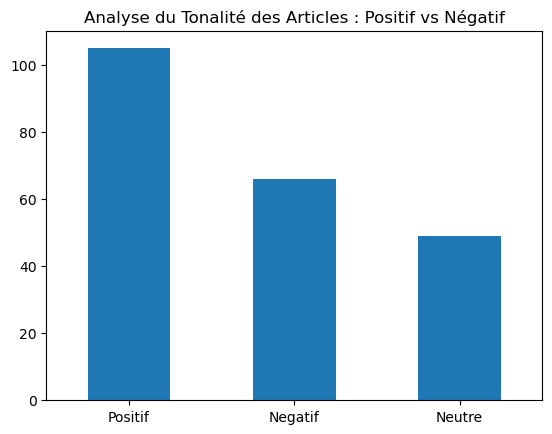

In [180]:
data["sentiment"].value_counts().plot.bar(rot=0)
plt.title("Analyse du Tonalité des Articles : Positif vs Négatif")
plt.show()

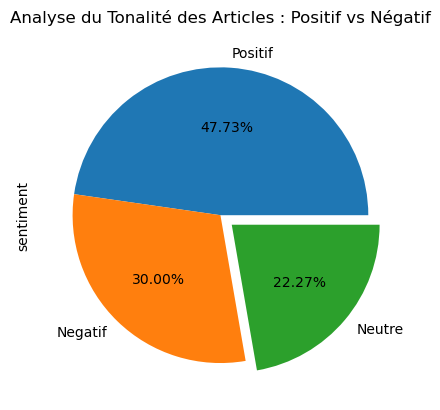

In [182]:
data["sentiment"].value_counts().plot.pie(autopct="%.2f%%",explode=(0,0,0.1))
plt.title("Analyse du Tonalité des Articles : Positif vs Négatif")
plt.show()

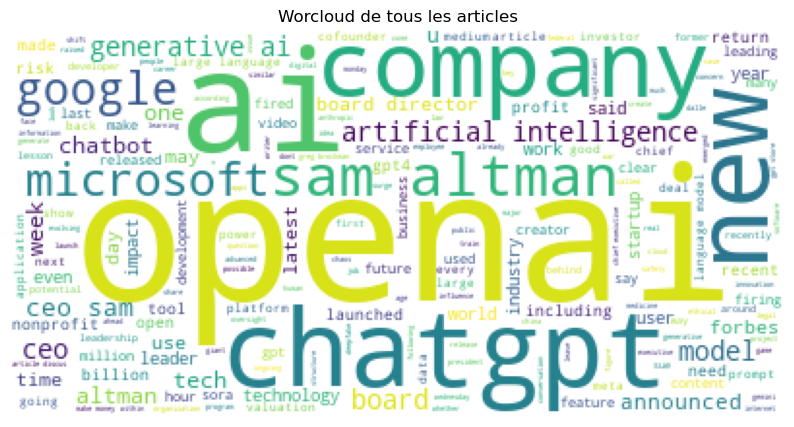

In [187]:
# Worclouds
texte = " ".join(data["content_nettoye"])
plt.figure(figsize=(10,10))
generate_worcloud(texte,"Worcloud de tous les articles")

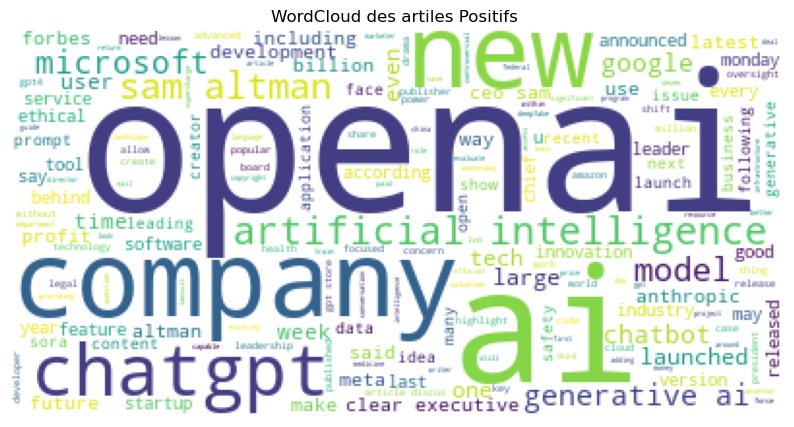

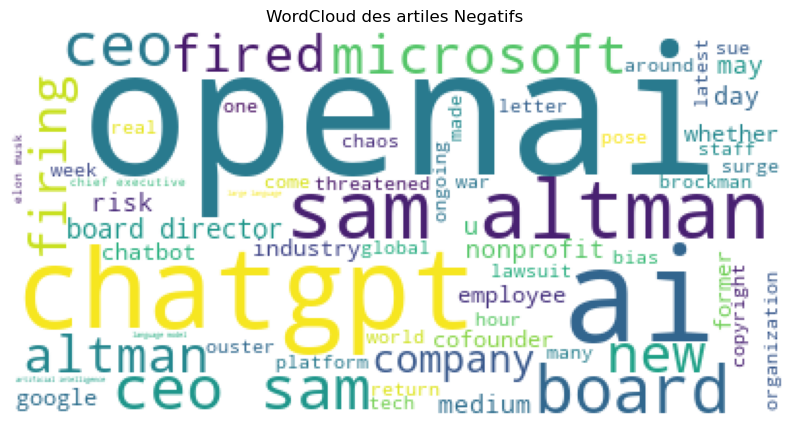

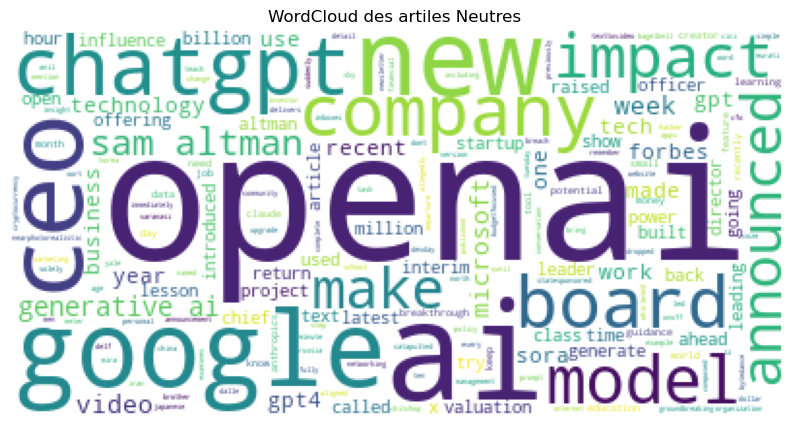

In [189]:
# WordCloud par type d'articles
sentiments = list(data.sentiment.unique())
for sentiment in sentiments :
    plt.subplots(figsize=(10,10))
    text = ' '.join(data.loc[data["sentiment"]==sentiment,"content_nettoye"])
    generate_worcloud(text,f"WordCloud des artiles {sentiment}s ")